In [30]:
# %%writefile Ind_MACD_TRE.py

import sys
import os 
module_path = os.path.abspath(os.path.join('..')) 
if module_path not in sys.path: 
    sys.path.append(module_path)

import numpy as np
import pandas as pd

import QUANTAXIS as QA

import tools.Sample_Tools as smpl
from base.JuUnits import excute_for_multidates

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker



def MACD_JCSC(data_series,SHORT=12,LONG=26,M=9,fast_mode=False):
    def kerrel(stock_single):
        DIFF =QA.EMA(stock_single,SHORT) - QA.EMA(stock_single,LONG)
        DEA = QA.EMA(DIFF,M)
        MACD =2*(DIFF-DEA)

        if fast_mode:
            return pd.DataFrame({'MACD':MACD}) 

        CROSS_JC=QA.CROSS(DIFF,DEA)
        CROSS_SC=QA.CROSS(DEA,DIFF)
        return pd.DataFrame({'MACD':MACD,'DIFF':DIFF,'DEA':DEA,'CROSS_JC':CROSS_JC,'CROSS_SC':CROSS_SC})

    return excute_for_multidates(data_series, kerrel, level=1)

def MACD_plot(MACD_df,low_frequence=True,figsize=(1120/72,420/72)):
    fig = plt.figure(figsize=figsize)
    groups = MACD_df.groupby(level=1)
    for idx,item in enumerate(groups):
        inds_ = item[1].reset_index('code',drop=True)
        # ax = fig.add_subplot(len(groups),1,idx+1)


        ##axis不转成字符串的话，bar和line的x轴有时候对不上，原因未知

        formater = '%Y%m%d' if low_frequence else '%Y%m%d %H%M%S'
        index_ = [pd.to_datetime(x).strftime(formater) for x in inds_.index.values]
#             d = item[1].reset_index(('date','code'),drop=True)

        # ax.set_title(item[0],color='r', loc ='left', pad=-10) 
        DD = inds_[['DIFF','DEA']]
        DD.index = index_
        # DD.plot(kind='line', ax=ax)
        DD.plot(kind='line')
        # macd = inds_['MACD']
        # macd.index = index_
        # macd.plot(kind='bar', ax=ax)
        # ax.xaxis.set_major_locator(ticker.MaxNLocator(10))
        plt.xticks(rotation = 0)
        plt.show()
        if idx >=2:
            break
    

In [85]:
from tools.Cacher import (CACHE_TYPE, save_cache,load_cache_adv,load_cache)

tail = False
if tail:
    file = 'all_tail_qfq'
else:
    file = 'all_train_qfq'
    
df_all = load_cache(file,cache_type=CACHE_TYPE.STOCK).sort_index()
smpl.optimize_data_type(df_all)


year = '2020'
data_ = df_all.loc[year+'-01-03':year+'-12-28']
codes = data_.index.get_level_values(1).unique()
dates = data_.index.get_level_values(0).unique()


ret = smpl.get_forward_return(data_,'close')
ret.name = 'ret_forward'
ret[np.abs(ret)>0.15]=np.nan




In [82]:
MACD_close = MACD_JCSC(data_.close)

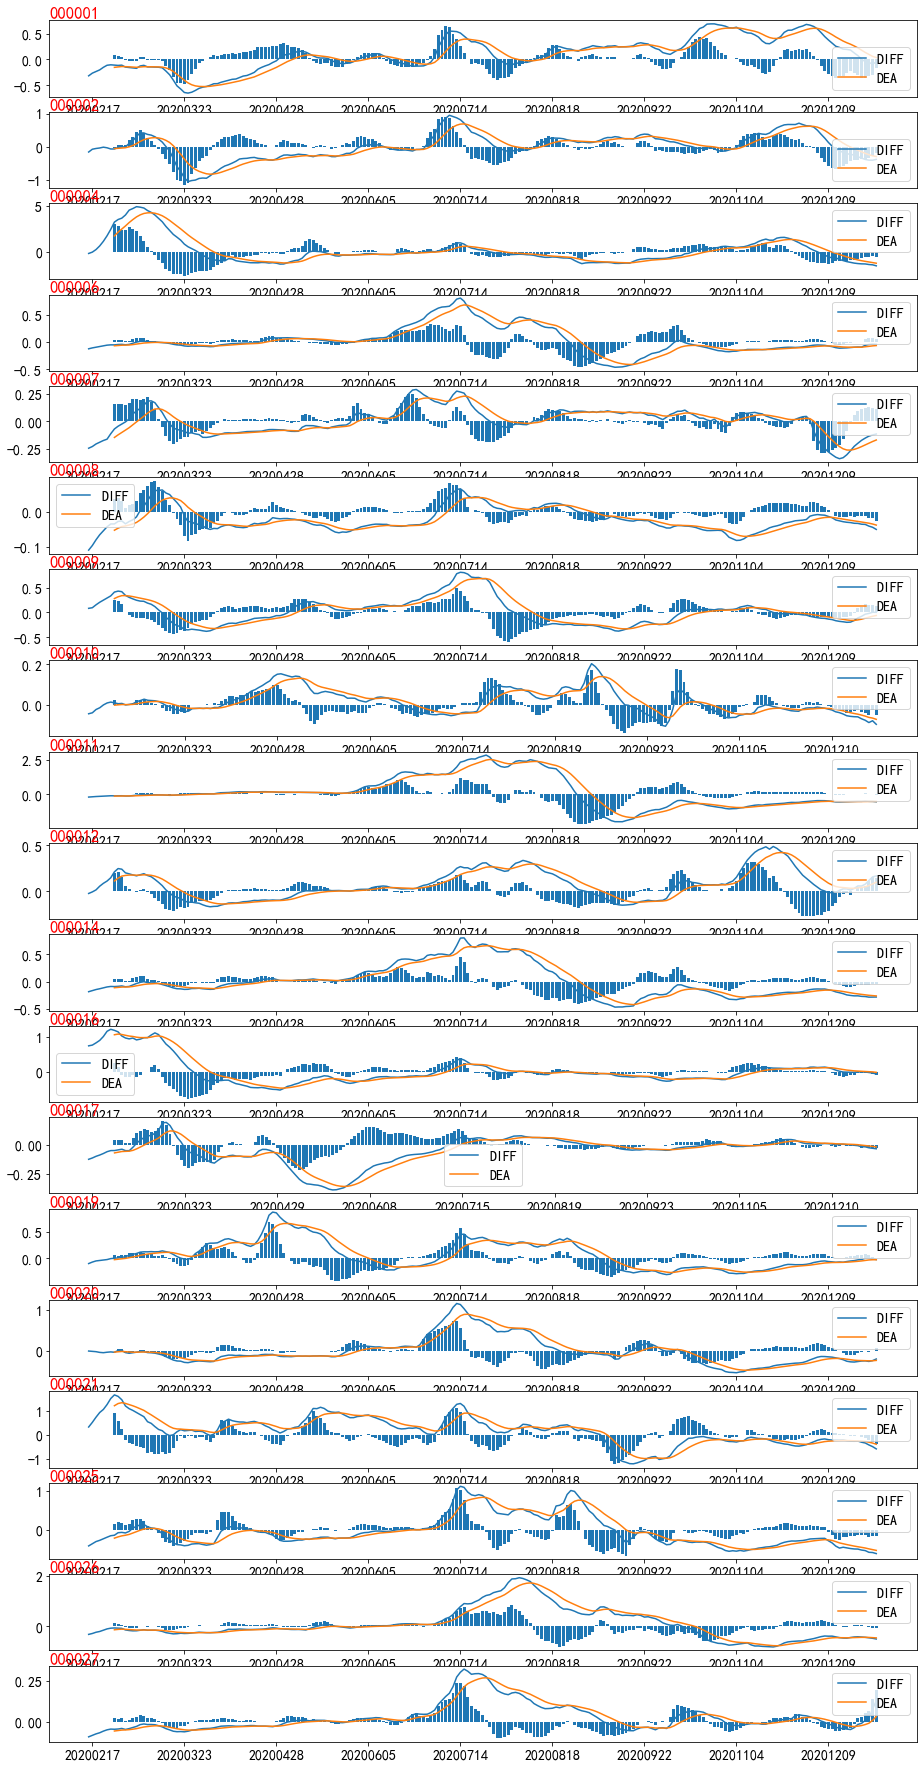

In [81]:
def MACD_plot(MACD_df,low_frequence=True):
    groups = MACD_df.groupby(level=1)
    assert len(groups)<20,'不允许超过20组'
    fig = plt.figure(figsize=(1120/72,120*len(groups)/72))
    for idx,item in enumerate(groups):
        inds_ = item[1].reset_index('code',drop=True)
        
        ax = fig.add_subplot(len(groups),1,idx+1)
        ax.xaxis.set_major_locator(ticker.MaxNLocator(10))
        
        ##axis不转成字符串的话，bar和line的x轴有时候对不上，原因未知
        formater = '%Y%m%d' if low_frequence else '%Y%m%d %H%M%S'
        index_ = [pd.to_datetime(x).strftime(formater) for x in inds_.index.values]
#             d = item[1].reset_index(('date','code'),drop=True)

        ax.set_title(item[0],color='r', loc ='left', pad=-10) 
        DD = inds_[['DIFF','DEA']]
        DD.index = index_
        DD.plot(kind='line', ax=ax)
        macd = inds_['MACD']
        ax.bar(index_,macd.values)
        plt.xticks(rotation = 0)

MACD_plot(MACD_close.loc[(slice(None),MACD_close.index.get_level_values(1).unique()[0:19]),])

In [83]:
MACD_close

MACD      DIFF       DEA  CROSS_JC  CROSS_SC
date       code                                                    
2020-01-03 000001       NaN       NaN       NaN         0         0
           000002       NaN       NaN       NaN         0         0
           000004       NaN       NaN       NaN         0         0
           000006       NaN       NaN       NaN         0         0
           000007       NaN       NaN       NaN         0         0
...                     ...       ...       ...       ...       ...
2020-12-28 605376       NaN       NaN       NaN         0         0
           605377       NaN       NaN       NaN         0         0
           605388 -0.444077  0.607817  0.829856         0         0
           605399 -0.301194 -0.476019 -0.325422         0         0
           605500       NaN       NaN       NaN         0         0

[667651 rows x 5 columns]

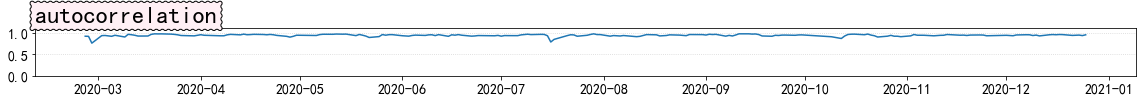

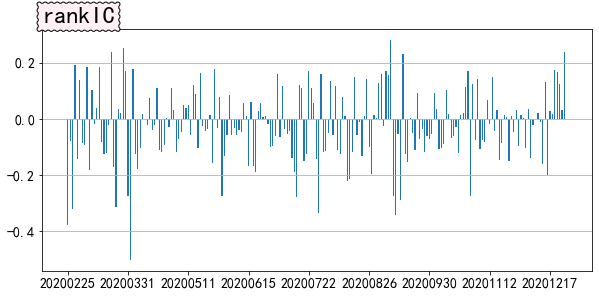

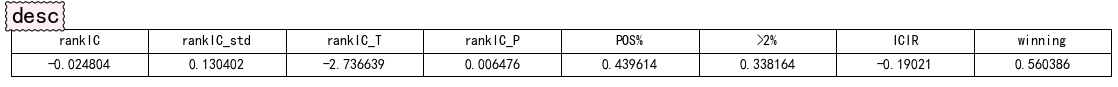

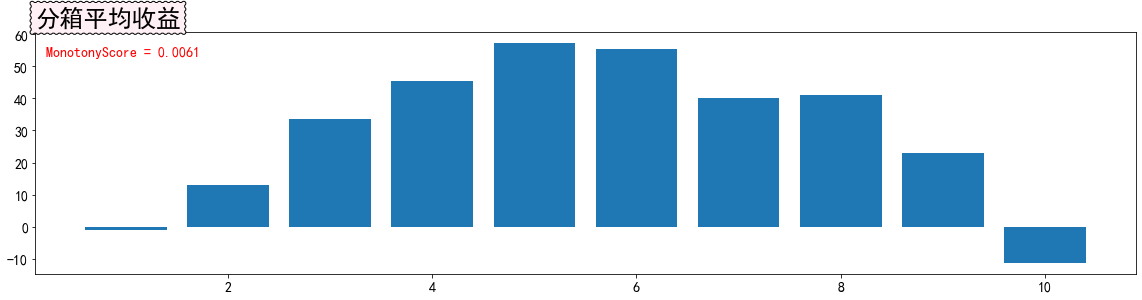

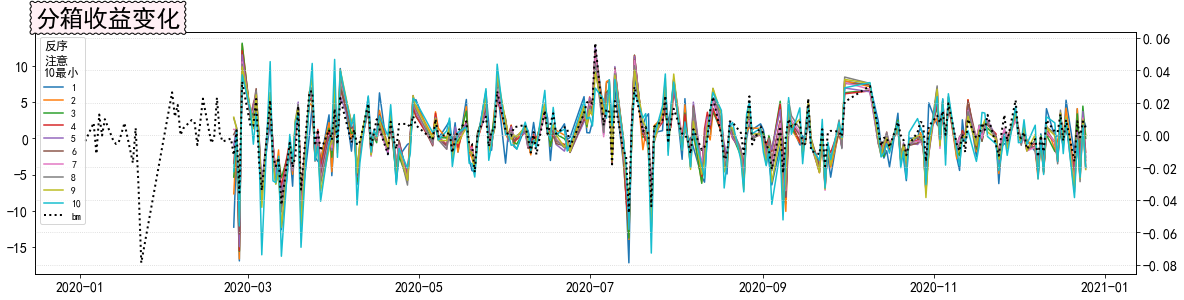

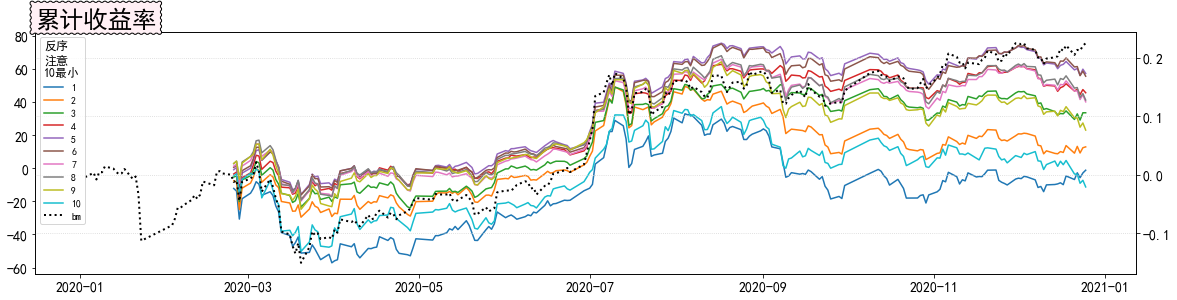

Wall time: 3.82 s


In [90]:
%%time
from tools.Test_Tools_Simple import FactorTest

# %load_ext autoreload
# %autoreload 1
# %aimport tools.Test_Tools_Simple

fa = pd.DataFrame(MACD_close.MACD).dropna()
fa.columns=['xxx']
test = FactorTest(start=dates.min().strftime('%Y-%m-%d'),end=dates.max().strftime('%Y-%m-%d'),target_field='xxx',blenchmark_name='沪深300', freq="d")
test.process_ind_simple(fa,ret,need_descript=True)
test.plot()
